In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## 1. Импорт данных 

In [3]:
df = pd.read_csv('Student.csv')
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## 2. Описательные статистики

In [15]:
desc_stats = df.describe().T 
desc_stats['cv'] = desc_stats['std'] / desc_stats['mean'] # Коэффициент вариации
desc_stats['skewness'] = df.skew(numeric_only=True) # Коэффициент асимметрии
desc_stats['kurtosis'] = df.kurtosis(numeric_only=True) # Коэффициент Эксцессa
desc_stats

,count,mean,std,min,25%,50%,75%,max,cv,skewness,kurtosis
Hours_Studied,6607.0,19.975329,5.990594,1.0,16.0,20.0,24.0,44.0,0.299900,0.013499,0.017771
Attendance,6607.0,79.977448,11.547475,60.0,70.0,80.0,90.0,100.0,0.144384,0.013666,-1.194407
Sleep_Hours,6607.0,7.029060,1.468120,4.0,6.0,7.0,8.0,10.0,0.208864,-0.023805,-0.503697
Previous_Scores,6607.0,75.070531,14.399784,50.0,63.0,75.0,88.0,100.0,0.191817,-0.003737,-1.191080
Tutoring_Sessions,6607.0,1.493719,1.230570,0.0,1.0,1.0,2.0,8.0,0.823830,0.815530,0.643718
Physical_Activity,6607.0,2.967610,1.031231,0.0,2.0,3.0,4.0,6.0,0.347495,-0.031365,-0.059439
Exam_Score,6607.0,67.235659,3.890456,55.0,65.0,67.0,69.0,101.0,0.057863,1.644808,10.575423


`Skewness (асимметрия)` — измеряет, насколько распределение данных сдвинуто влево или вправо от среднего.

1) Если skewness > 0, распределение скошено вправо (длинный "хвост" справа).

2) Если skewness < 0, скошено влево (длинный "хвост" слева).

3) Если skewness ≈ 0, распределение примерно симметрично.

`Kurtosis (эксцесс)` — измеряет "остроту" пиков распределения по сравнению с нормальным распределением.

1) Если kurtosis > 0 — распределение с более острым пиком и более "тяжёлыми хвостами" (лептокуртическое).

2) Если kurtosis < 0 — распределение более плоское, чем нормальное (платикуртическое).

3) Если kurtosis ≈ 0 — распределение близко к нормальному (мезокуртическое).

Иначе говоря:

Асимметрия показывает, есть ли сдвиг в данных вправо или влево.

Эксцесс — насколько часто встречаются экстремальные значения (высокие/низкие).

## 3. Гистограммы и "ящики с усами"

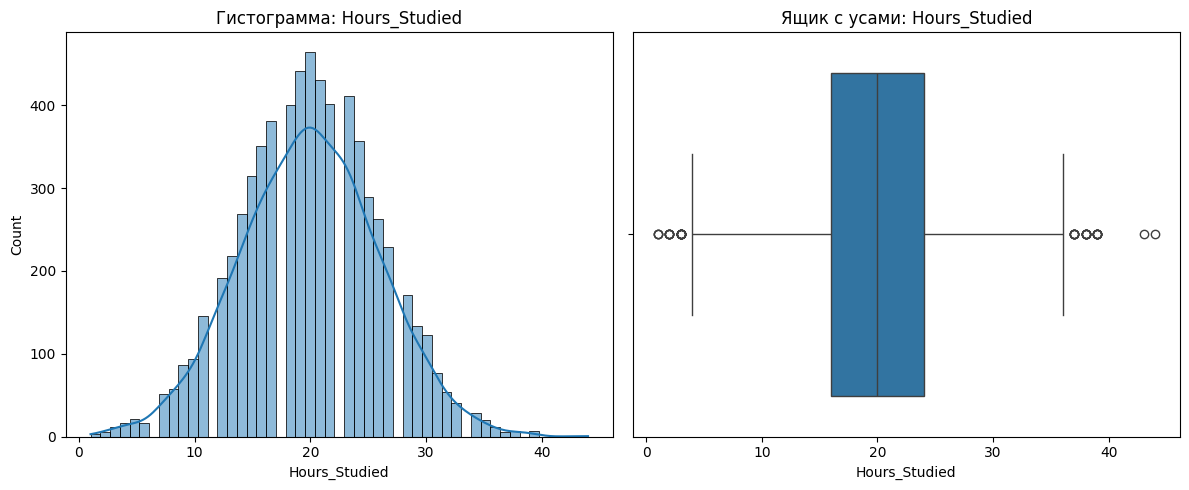

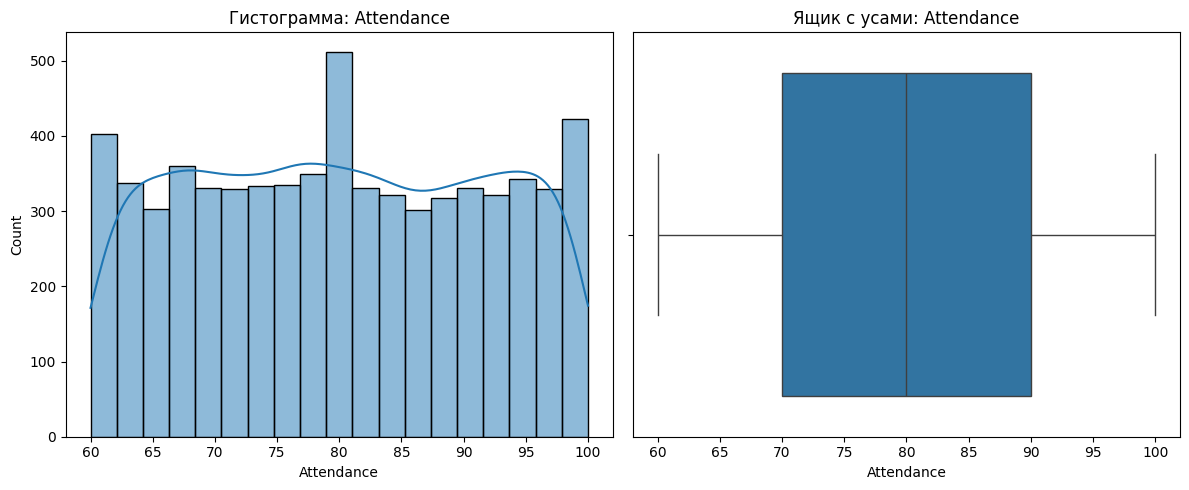

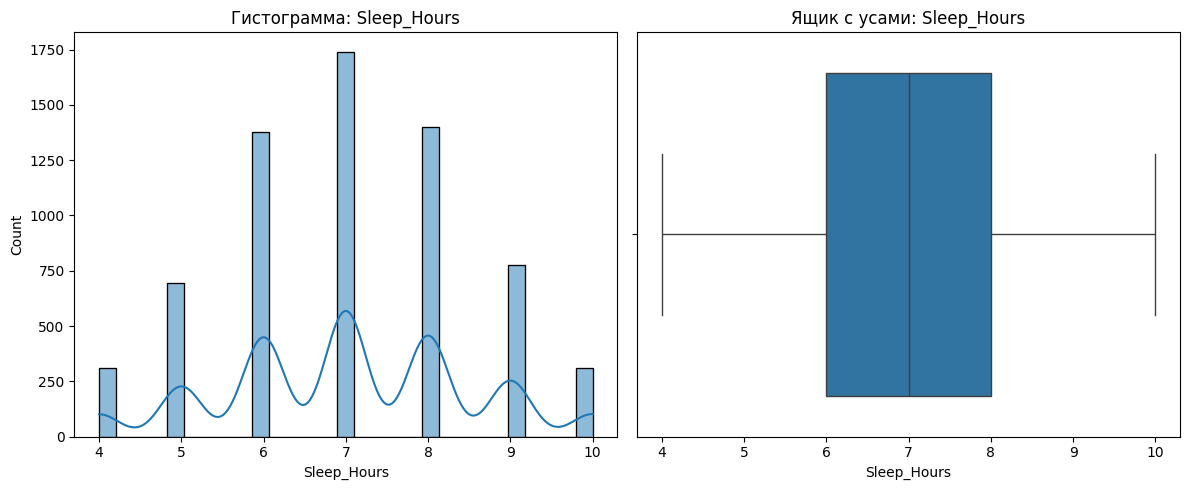

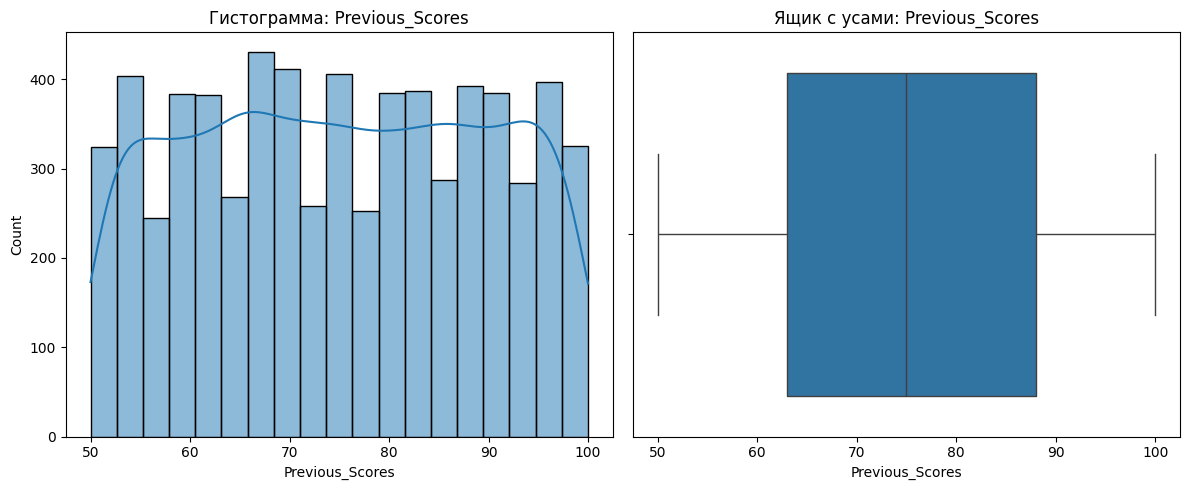

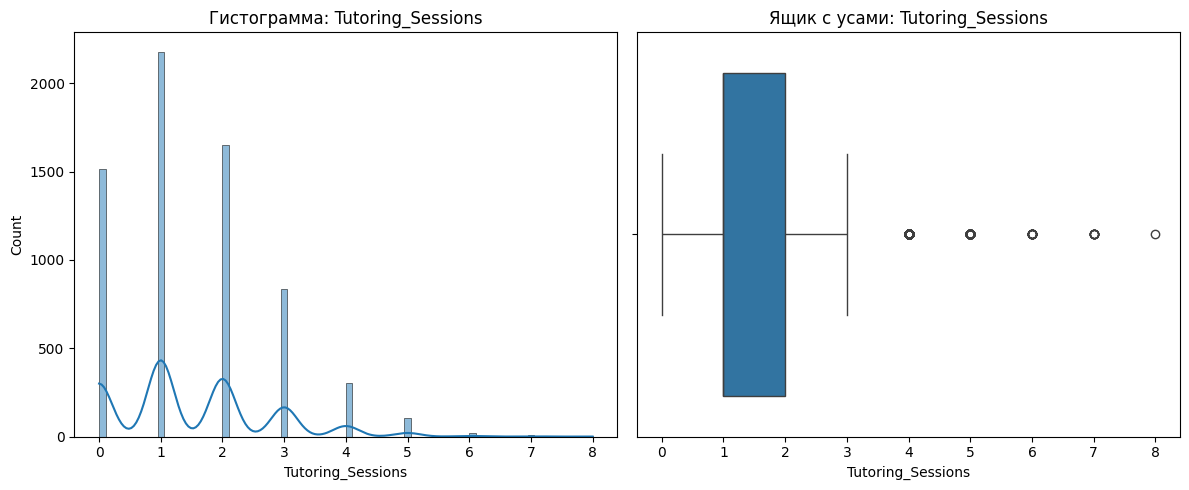

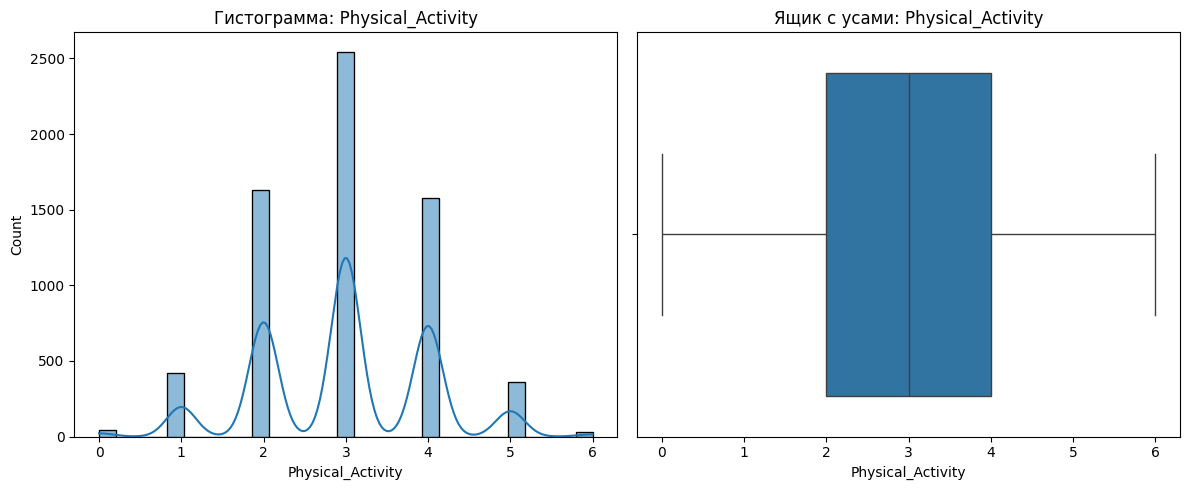

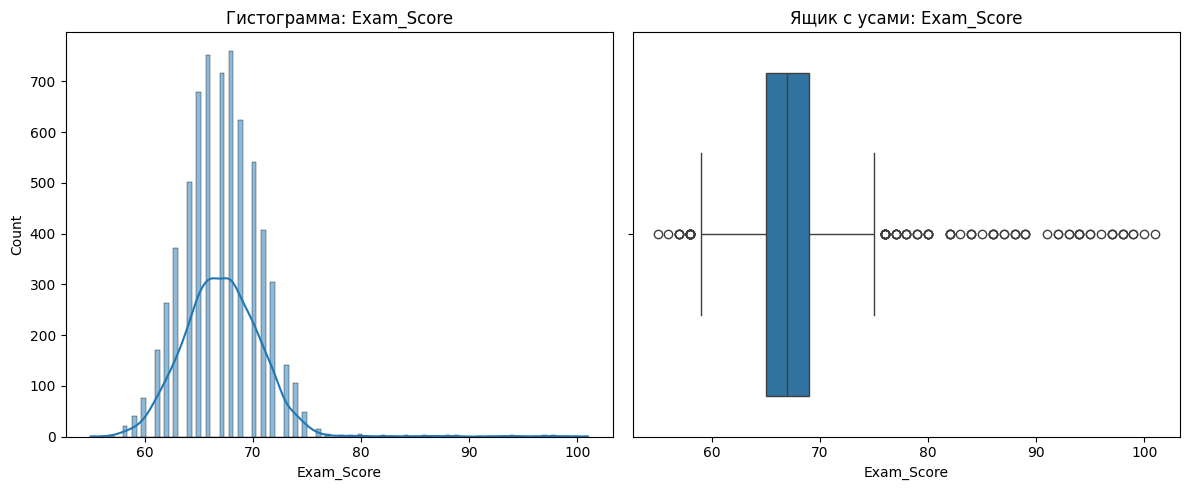

In [22]:
for column in df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Гистограмма: {column}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Ящик с усами: {column}')

    plt.tight_layout()
    plt.show()

###  Гистограмма
`нормальное распределение:`
```
Симметричная "колоколообразная" форма.
Один явный пик (монотонная мода).
Плавный спад к краям с обеих сторон.
Отсутствие резких "ступенек" и выбросов.
```
`ненормального распределения:`
```
Асимметрия (лево- или правосторонний сдвиг).
Много пиков → мультимодальность.
Плоское или слишком острое распределение.
Длинные хвосты (fat tails).
```
### Ящик
`нормальный`
```
Ящик (межквартильный размах) почти симметричен.
Усы (хвосты) примерно одинаковой длины.
Мало или нет выбросов (точек за пределами усов).
```
`ненорм`
```
Ящик сдвинут в одну сторону (асимметрия).
Один ус длиннее другого.
Много выбросов с одной стороны.
```

## 4. Проверка нормальности распределения (Shapiro-Wilk)

In [82]:
normality_results = {
    col: (stats.shapiro(df[col].dropna())[0],  # W
          round(stats.shapiro(df[col].dropna())[1], 10))  # p-value
    for col in df.select_dtypes(include=['int64']).columns}
pd.DataFrame.from_dict(normality_results, orient='index', columns=['W', 'p-value'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6607.
  res = hypotest_fun_out(*samples, **kwds)


,W,p-value
Hours_Studied,0.997433,3.600000e-09
Attendance,0.954794,0.000000e+00
Sleep_Hours,0.952896,0.000000e+00
Previous_Scores,0.955421,0.000000e+00
Tutoring_Sessions,0.890143,0.000000e+00
Physical_Activity,0.921318,0.000000e+00
Exam_Score,0.902914,0.000000e+00


W — статистика теста, показатель, насколько данные похожи на нормальное распределение.

p-value — вероятность получить наблюдаемые данные, если данные на самом деле распределены нормально.
```
p > 0.05 → распределение можно считать нормальным.
p ≤ 0.05 → отклоняется от нормального.
```

## 5. Попарные графики зависимости от Y

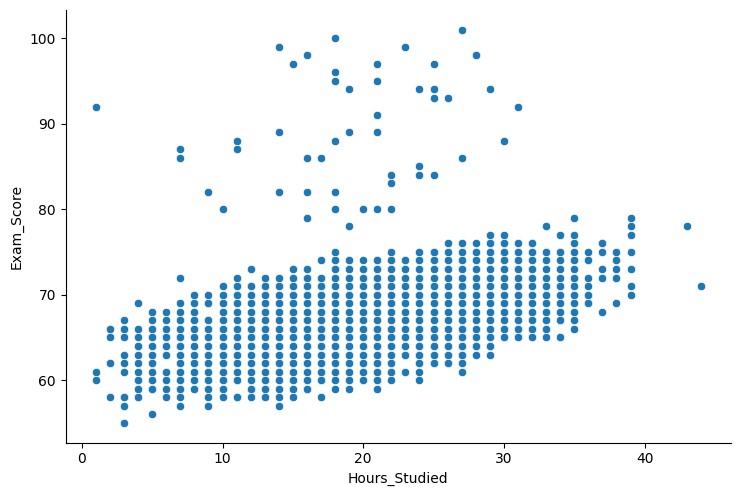

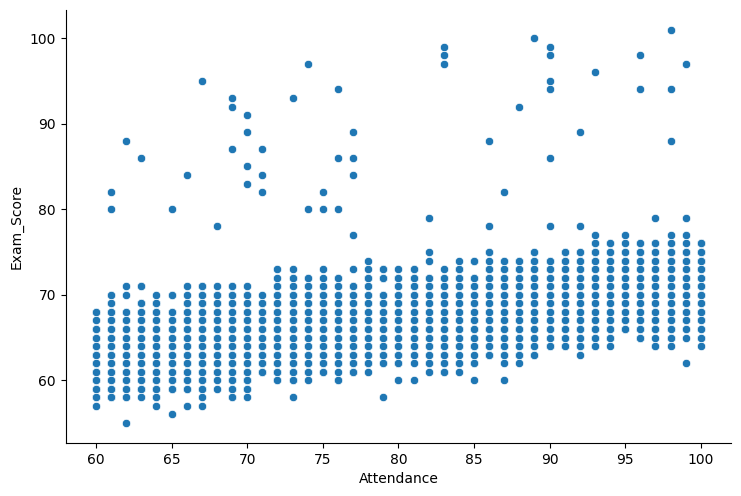

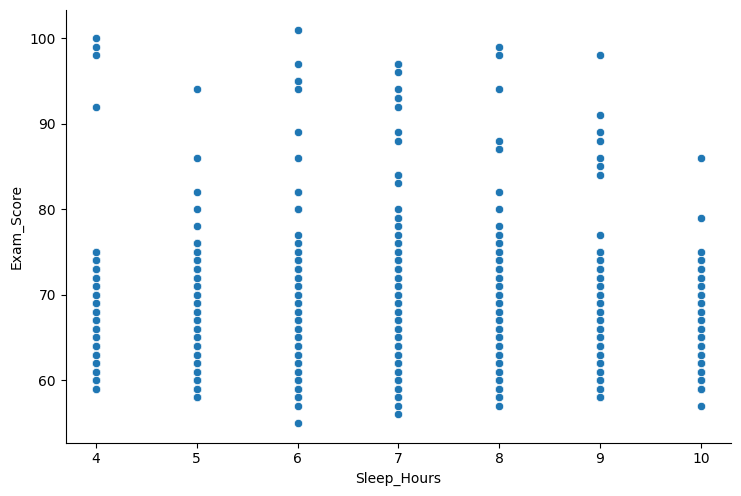

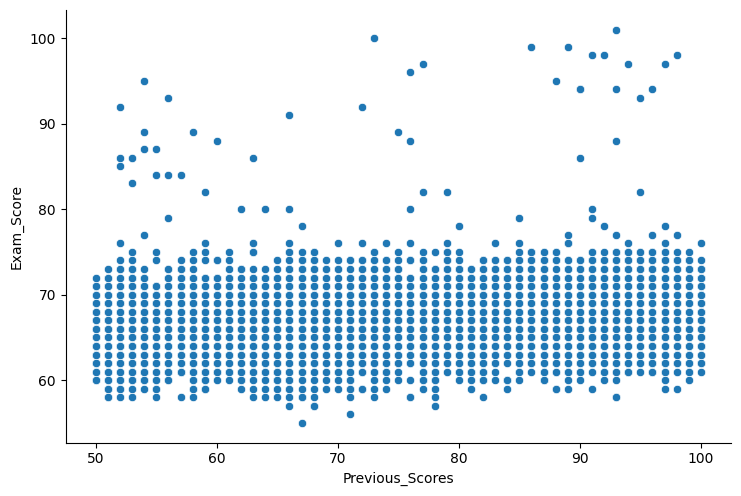

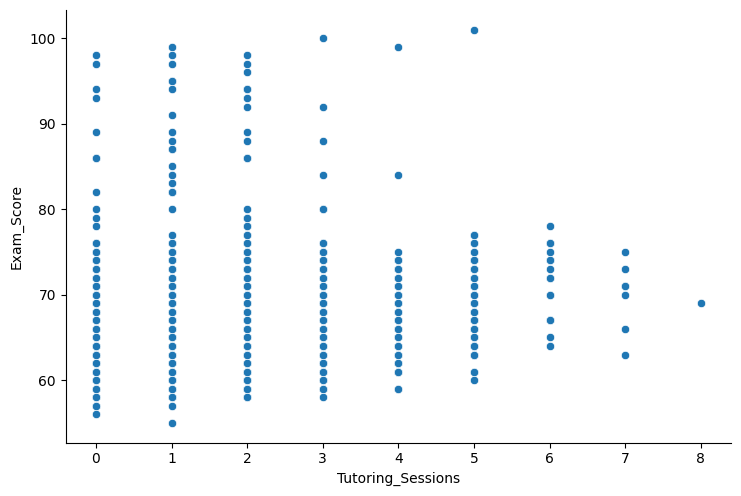

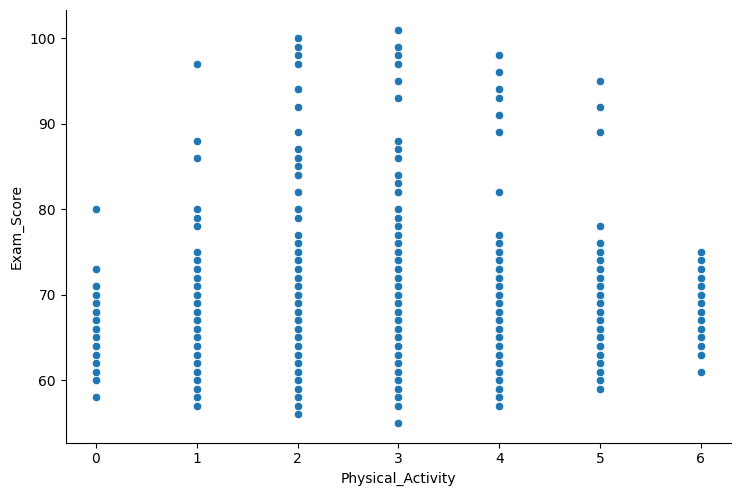

In [62]:
target = 'Exam_Score'

for i, col in enumerate(df.select_dtypes(include=['int64']).columns, 1):
    if col != target:
        sns.pairplot(data=df, x_vars=col, y_vars=target, height=5, aspect=1.5)
plt.show()

`Линейная зависимость`
Если точки формируют приблизительно прямую линию (вверх или вниз) → есть линейная зависимость.
```
Пример:
Вверх: больше часов учёбы → выше балл
Вниз: больше прогулов → ниже балл
```

`Нелинейность`
```
Если точки образуют изогнутую форму (U-образную, S-образную) → возможна нелинейная зависимость.
В таких случаях линейная регрессия не подойдёт напрямую.
```

`Отсутствие зависимости`
```
Если точки разбросаны хаотично, без видимого направления → зависимость отсутствует или она слабая.
```

`Выбросы (outliers)`
```
Точки, которые сильно выбиваются из общей массы — могут искажать корреляции и регрессию.
Их нужно проверить отдельно.
```

## 6. Корреляционная матрица

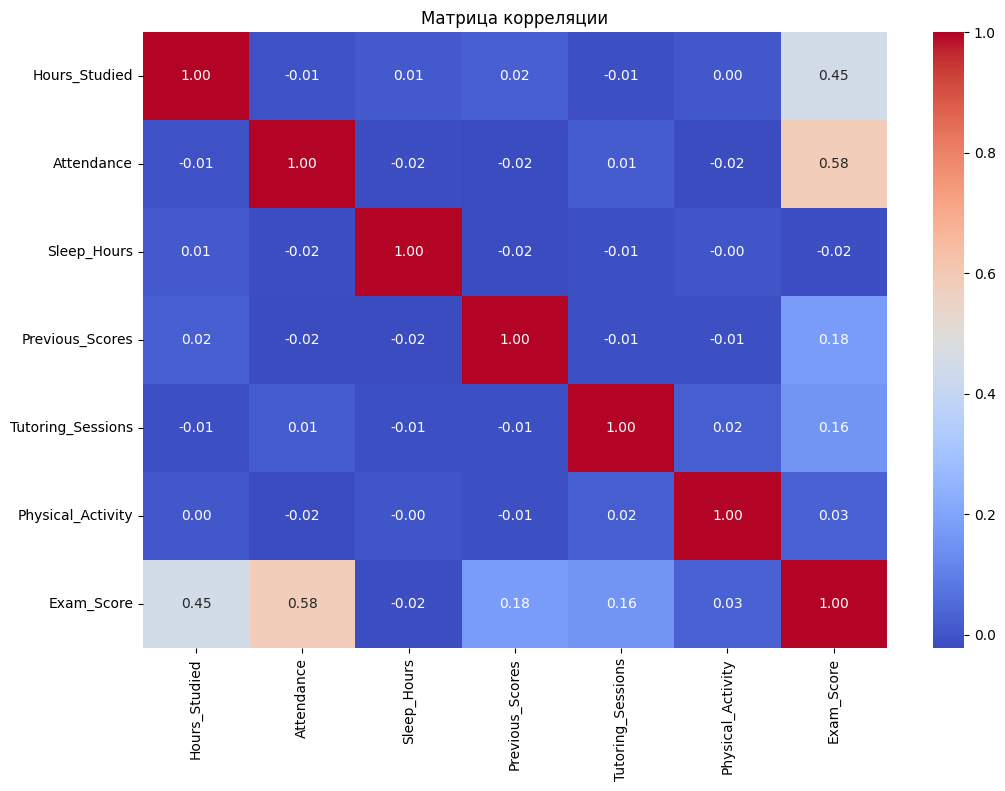

In [85]:
correlation_matrix = df.select_dtypes(include=['int64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Матрица корреляции')
plt.show()

## 7 Построение уравнения регрессии

In [89]:
X = df.select_dtypes(include=['int64']).drop(columns=target)
X = sm.add_constant(X)  # Добавление константы
y = df[target]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     1638.
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        02:19:25   Log-Likelihood:                -15338.
No. Observations:                6607   AIC:                         3.069e+04
Df Residuals:                    6600   BIC:                         3.074e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                40.9271      0.33

Показатель->Значение->Что значит
```
R-squared	0.598	Модель объясняет 59.8% дисперсии экзаменационного балла. Хорошо, но не идеально.
Adj. R-squared	0.598	Уточнённая версия R², учитывает число предикторов. Почти то же — хорошо.
F-statistic	1638	Статистика для всей модели. Большое значение → модель значима.
Prob (F-statistic)	0.000	Очень маленькое значение (p ≤ 0.05) → модель значима.
```

1) | const | 40.927 | 0.000 | Базовое значение, когда все факторы = 0 |
2) | Hours_Studied | 0.292 | 0.000 | +1 час учебы → +0.29 к баллу (значимая переменная) |
3) | Attendance | 0.198 | 0.000 | +1% посещаемости → +0.198 к баллу (значимая переменная) |
4) | Sleep_Hours | -0.018 | 0.384 | НЕзначимая переменная (p > 0.05) → сон не влияет |
5) | Previous_Scores | 0.048 | 0.000 | +1 к предыдущим баллам → +0.048 к новому (значимо) |
6) | Tutoring_Sessions | 0.494 | 0.000 | Занятия с репетитором заметно улучшают балл |
7) | Physical_Activity | 0.144 | 0.000 | Умеренное положительное влияние (значимо) |

## 8. Исключение статистически незначимых регрессоров

In [90]:
while True:
    model = sm.OLS(y, X).fit()
    max_p = model.pvalues.drop('const').max()
    if max_p > 0.05:
        excluded_var = model.pvalues.drop('const').idxmax()
        X = X.drop(columns=excluded_var)
    else:
        break

print(model.summary())

Удаляется переменная: Sleep_Hours (p-value = 0.3837)
                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     1966.
Date:                Sat, 17 May 2025   Prob (F-statistic):               0.00
Time:                        02:26:54   Log-Likelihood:                -15338.
No. Observations:                6607   AIC:                         3.069e+04
Df Residuals:                    6601   BIC:                         3.073e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

### Формула
`
Y=b0+b1x1+b2x
`
```
Exam_Score=40.7949+0.2915⋅Hours_Studied+0.1980⋅Attendance+0.0482⋅Previous_Scores+0.4938⋅Tutoring_Sessions+0.1440⋅Physical_Activity
```

In [5]:
line = df.select_dtypes(include=['int64']).head(1)
line

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
0,23,84,7,73,0,3,67


In [7]:
score = 40.7949 + 0.2915*line['Hours_Studied'] + 0.1980*line['Attendance'] + 0.0482 * line['Previous_Scores'] +0.4938*line['Tutoring_Sessions']+ 0.1440*line['Physical_Activity']
score

0    68.082
dtype: float64